<a href="https://colab.research.google.com/github/Kevontym/DataScience/blob/main/Forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import pandas as pd
import os

# Define the folder containing the CSVs
folder_path = '/content/drive/MyDrive/Z-score'

# Create an empty list to store DataFrames
dfs = []

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dfs.append(df)

# Combine all DataFrames into one (optional)
combined_df = pd.concat(dfs, ignore_index=True)

# Check the combined data
print(combined_df.head())

threshold = df['Close'].mean()  # Example: Using the mean of the 'Close' column as the threshold
df['Target'] = df['Close'].apply(lambda x: 1 if x > threshold else 0)

# Verify the target column
print("Target distribution:\n", df['Target'].value_counts())

# View the first few rows of the DataFrame to ensure the target is added
print(df.head())

             Timestamp      Open      High       Low     Close     upperband  \
0  2024-03-07 00:00:00 -0.974675 -0.985279 -0.957956 -0.964549 -3.959425e-15   
1  2024-03-07 00:01:00 -0.978850 -0.988064 -0.957956 -0.964549 -3.959425e-15   
2  2024-03-07 00:02:00 -0.984912 -0.990293 -0.969051 -0.974284 -3.959425e-15   
3  2024-03-07 00:03:00 -0.990261 -0.991129 -0.966278 -0.966774 -3.959425e-15   
4  2024-03-07 00:04:00 -0.981911 -0.990571 -0.960730 -0.967887 -3.959425e-15   

   middleband  lowerband  SMA           EMA  RSI          MACD   MACD_signal  \
0         0.0        0.0  0.0  7.905981e-15  0.0  3.046578e-19  9.696720e-19   
1         0.0        0.0  0.0  7.905981e-15  0.0  3.046578e-19  9.696720e-19   
2         0.0        0.0  0.0  7.905981e-15  0.0  3.046578e-19  9.696720e-19   
3         0.0        0.0  0.0  7.905981e-15  0.0  3.046578e-19  9.696720e-19   
4         0.0        0.0  0.0  7.905981e-15  0.0  3.046578e-19  9.696720e-19   

      MACD_hist         slowk         

In [ ]:
from sklearn.model_selection import train_test_split

# Define your features and target
features = df.drop(columns=['Target'])  # Assuming 'Target' is your label column
target = df['Target']

# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (210560, 17), (210560,)
Testing set shape: (52640, 17), (52640,)


In [ ]:

import torch

# Drop the 'Date' column if it's present in your features
X_train = X_train.select_dtypes(include=[float, int])  # Keep only numeric columns
X_test = X_test.select_dtypes(include=[float, int])

# Now convert the remaining data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
import torch

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class ForexNN(nn.Module):
    def __init__(self, input_size):
        super(ForexNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Input layer
        self.fc2 = nn.Linear(128, 64)  # Hidden layer
        self.fc3 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

# Initialize the model
model = ForexNN(input_size=X_train_tensor.shape[1])

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the model
epochs = 50
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.4908
Epoch [20/50], Loss: 0.3098
Epoch [30/50], Loss: 0.1818
Epoch [40/50], Loss: 0.1110
Epoch [50/50], Loss: 0.0741


In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_labels = torch.round(predictions).squeeze()

# Convert predictions to numpy for comparison
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_labels.numpy())
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9966


Performing very well


In [ ]:
# Evaluate on training data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_train_pred = model(X_train_tensor)
    y_train_pred_labels = torch.round(y_train_pred).detach().numpy()

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_tensor, y_train_pred_labels)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9966


In [ ]:
from sklearn.model_selection import KFold

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Adjust n_splits as needed

# Assuming X_train_tensor and y_train_tensor are your data tensors
cross_val_accuracies = []

for train_idx, val_idx in kf.split(X_train_tensor):
    X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
    y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

    # Train the model
    model.train()
    optimizer.zero_grad()
    output = model(X_train_fold)

    # Reshape the target to match the output shape
    loss = criterion(output, y_train_fold.view(-1, 1))
    loss.backward()
    optimizer.step()

    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_fold)
        y_val_pred_labels = torch.round(y_val_pred).detach().numpy()
        val_accuracy = accuracy_score(y_val_fold.numpy(), y_val_pred_labels)
        cross_val_accuracies.append(val_accuracy)

print(f"Cross-validation Accuracies: {cross_val_accuracies}")
print(f"Mean Cross-validation Accuracy: {sum(cross_val_accuracies) / len(cross_val_accuracies):.4f}")

Cross-validation Accuracies: [0.996343085106383, 0.9967467705167173, 0.9967467705167173, 0.9969129939209727, 0.997079217325228]
Mean Cross-validation Accuracy: 0.9968


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize lists to store the metrics
cross_val_precisions = []
cross_val_recalls = []
cross_val_f1_scores = []

for train_idx, val_idx in kf.split(X_train_tensor):
    X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
    y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

    # Train the model
    model.train()
    optimizer.zero_grad()
    output = model(X_train_fold)

    # Reshape the target to match the output shape
    loss = criterion(output, y_train_fold.view(-1, 1))
    loss.backward()
    optimizer.step()

    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_fold)
        y_val_pred_labels = torch.round(y_val_pred).detach().numpy()

        # Calculate precision, recall, and F1-score
        precision = precision_score(y_val_fold.numpy(), y_val_pred_labels)
        recall = recall_score(y_val_fold.numpy(), y_val_pred_labels)
        f1 = f1_score(y_val_fold.numpy(), y_val_pred_labels)

        cross_val_precisions.append(precision)
        cross_val_recalls.append(recall)
        cross_val_f1_scores.append(f1)

# Output the average metrics
print(f"Mean Cross-validation Precision: {sum(cross_val_precisions) / len(cross_val_precisions):.4f}")
print(f"Mean Cross-validation Recall: {sum(cross_val_recalls) / len(cross_val_recalls):.4f}")
print(f"Mean Cross-validation F1-score: {sum(cross_val_f1_scores) / len(cross_val_f1_scores):.4f}")

Mean Cross-validation Precision: 0.9958
Mean Cross-validation Recall: 0.9985
Mean Cross-validation F1-score: 0.9971


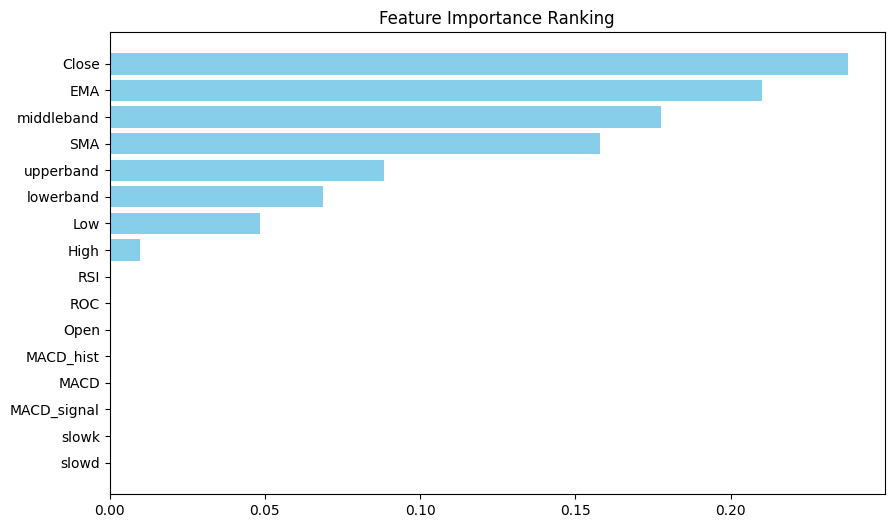

        Feature  Importance
3         Close    0.237637
8           EMA    0.210123
5    middleband    0.177631
7           SMA    0.158043
4     upperband    0.088355
6     lowerband    0.068823
2           Low    0.048406
1          High    0.009683
9           RSI    0.000389
15          ROC    0.000331
0          Open    0.000214
12    MACD_hist    0.000186
10         MACD    0.000102
11  MACD_signal    0.000037
13        slowk    0.000020
14        slowd    0.000019


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Initialize a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_

# Create a DataFrame for feature importance ranking
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance Ranking')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Display the ranked features
print(feature_importance_df)

        Feature   Coefficient
1          High  2.226244e-01
3         Close  1.541814e-01
0          Open  6.477700e-02
4     upperband  3.145322e-02
13        slowk  2.426013e-02
12    MACD_hist  6.584211e-03
14        slowd  4.441412e-03
9           RSI  1.627221e-03
8           EMA  5.518080e-07
15          ROC -6.122096e-03
11  MACD_signal -1.491473e-02
2           Low -6.795961e-02


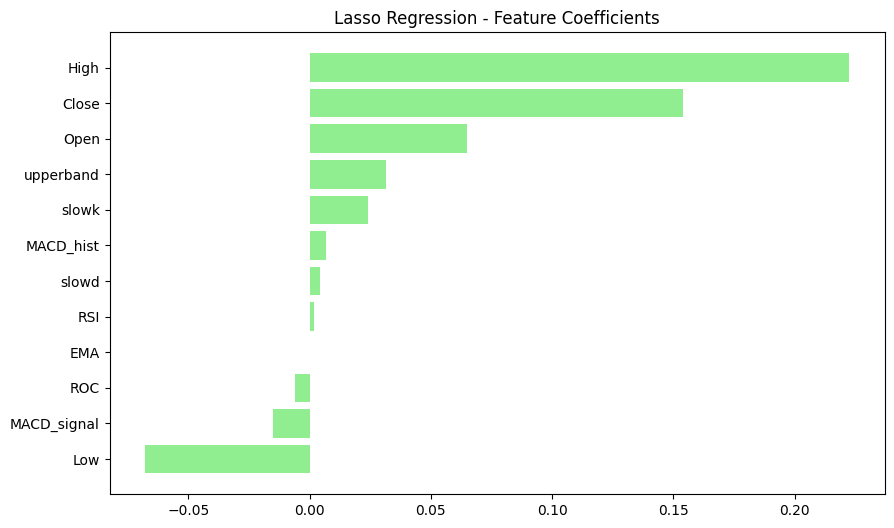

In [ ]:
from sklearn.linear_model import LassoCV

# Initialize Lasso with cross-validation
lasso = LassoCV(cv=5, random_state=42)

# Fit the model
lasso.fit(X_train, y_train)

# Get the coefficients (non-zero coefficients indicate important features)
lasso_coefs = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso.coef_})
lasso_coefs = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

# Display the important features
print(lasso_coefs)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.title('Lasso Regression - Feature Coefficients')
plt.barh(lasso_coefs['Feature'], lasso_coefs['Coefficient'], color='lightgreen')
plt.gca().invert_yaxis()
plt.show()

After testing lets retrain with the best features

In [ ]:
# Example: Combine your training tensors (features and targets)
# Assuming you already have X_train_tensor and y_train_tensor from previous steps

# Combine features (you can concatenate multiple features if needed)
X_train_tensor_combined = X_train_tensor  # or torch.cat([X_train_tensor1, X_train_tensor2], dim=1)

# Assuming your test data is similarly prepared
X_test_tensor_combined = X_test_tensor  # or torch.cat([X_test_tensor1, X_test_tensor2], dim=1)

# Now rerun the train_model function

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define the range of hyperparameters
learning_rates = [0.01, 0.001, 0.0001]
neurons_layer1 = [64, 128]
neurons_layer2 = [32, 64]
batch_sizes = [32, 64]
epochs_list = [50, 100]

def train_model(lr, n1, n2, batch_size, epochs, patience=10):
    # Initialize model with the selected number of neurons and move to device
    model = ForexNN(input_size=X_train_tensor_combined.shape[1]).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Early stopping setup
    best_loss = float('inf')
    early_stop_count = 0

    # Training loop with batches
    num_batches = len(X_train_tensor_combined) // batch_size
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            inputs = X_train_tensor_combined[start_idx:end_idx]
            targets = y_train_tensor[start_idx:end_idx]

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Early stopping check
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor_combined)
        predicted = torch.round(test_outputs).squeeze()
        accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy())

    return accuracy

# Perform hyperparameter tuning by iterating over combinations
best_accuracy = 0
best_params = None
for lr in learning_rates:
    for n1 in neurons_layer1:
        for n2 in neurons_layer2:
            for batch_size in batch_sizes:
                for epochs in epochs_list:
                    print(f"Training with LR={lr}, Neurons_L1={n1}, Neurons_L2={n2}, Batch={batch_size}, Epochs={epochs}")
                    accuracy = train_model(lr, n1, n2, batch_size, epochs)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = (lr, n1, n2, batch_size, epochs)

print(f"Best Accuracy: {best_accuracy:.4f} with parameters: LR={best_params[0]}, Neurons_L1={best_params[1]}, Neurons_L2={best_params[2]}, Batch={best_params[3]}, Epochs={best_params[4]}")

Training with LR=0.01, Neurons_L1=64, Neurons_L2=32, Batch=32, Epochs=50


NameError: name 'device' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor_combined)
    predicted_labels = torch.round(predictions).squeeze()

# Convert predictions to numpy for comparison
predicted_labels = predicted_labels.numpy()
y_test_numpy = y_test_tensor.numpy()

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test_numpy, predicted_labels)
precision = precision_score(y_test_numpy, predicted_labels)
recall = recall_score(y_test_numpy, predicted_labels)
f1 = f1_score(y_test_numpy, predicted_labels)

# Print the evaluation metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

In [ ]:
print(f"Input feature size: {X_train_tensor.shape[1]}")